## Extreme Gradient Boosting Machine (XGBM) and Gradient Boosting Machine (GBM)

**A Gradient Boosting Machine or GBM** combines the predictions from multiple decision trees to generate the final predictions. Keep in mind that all the weak learners in a gradient boosting machine are decision trees.

if we are using the same algorithm, then how is using a hundred decision trees better than using a single decision tree? How do different decision trees capture different signals/information from the data?

Here is the trick – the nodes in every decision tree take a different subset of features for selecting the best split. This means that the individual trees aren’t all the same and hence they are able to capture different signals from the data.

Additionally, each new tree takes into account the errors or mistakes made by the previous trees. So, every successive decision tree is built on the errors of the previous trees. This is how the trees in a gradient boosting machine algorithm are built sequentially.

**Extreme Gradient Boosting or XGBoost** is another popular boosting algorithm. In fact, XGBoost is simply an improvised version of the GBM algorithm! The working procedure of XGBoost is the same as GBM. The trees in XGBoost are built sequentially, trying to correct the errors of the previous trees.

But there are certain features that make XGBoost slightly better than GBM:

1. One of the most important points is that XGBM implements parallel preprocessing (at the node level) which makes it faster than GBM.
2. XGBoost also includes a variety of regularization techniques that reduce overfitting and improve overall performance. You can select the regularization technique by setting the hyperparameters of the XGBoost algorithm.
3. if you are using the XGBM algorithm, you don’t have to worry about imputing missing values in your dataset. The XGBM model can handle the missing values on its own. During the training process, the model learns whether missing values should be in the right or left node.


In [93]:
## Lets see how XGBM improve teh accuracy of model. It works very good If we have very very large datasets.
## We will get very much difference with very less amount of dataset.

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from xgboost import XGBClassifier
import xgboost as XGB
from sklearn import metrics

We are using UCI dataset and this is the classic “Adult Data Set”. An older set from 1996, this dataset contains census data on income. Our job is to predict whether a certain individual had an income of greater than 50,000 based on their demographic information.

In [43]:
## I downloaded both files and store at my Github profile.
df_adult = pd.read_csv("https://raw.githubusercontent.com/atulpatelDS/Data_Files/master/UCI_Adult/adult.csv")

In [44]:
df_adult.head()


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [45]:
print(df_adult.shape)
print(type(df_adult))

(48842, 15)
<class 'pandas.core.frame.DataFrame'>


In [46]:
qq = df_adult["age"].dtypes

In [47]:
qq

dtype('int64')

In [48]:
## Check the intial data type, null value and unique counts
def initial_dataset_check(df):
    """
    A function to make initial check for the dataset including the name, data type, 
    number of null values and number of unique varialbes for each feature.
    """
    columns = df.columns    
    lst = []
    for feature in columns : 
        dtype = df[feature].dtypes
        num_null = df[feature].isnull().sum()
        num_unique = df[feature].nunique()
        lst.append([feature, dtype, num_null, num_unique])
    
    check_df = pd.DataFrame(lst)
    check_df.columns = ['feature','dtype','num_null','num_unique']
    check_df = check_df.sort_values(by='dtype', axis=0, ascending=True)
    
    return check_df

In [49]:
initial_dataset_check(df_adult)

,feature,dtype,num_null,num_unique
0,age,int64,0,74
2,fnlwgt,int64,0,28523
4,educational-num,int64,0,16
10,capital-gain,int64,0,123
11,capital-loss,int64,0,99
12,hours-per-week,int64,0,96
1,workclass,object,0,9
3,education,object,0,16
5,marital-status,object,0,7
6,occupation,object,0,15


In [50]:
df_adult.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [51]:
print(df_adult.income.unique())

['<=50K' '>50K']


In [53]:
## We can convert the value with 0 and 1
## <=50K == 0 and  >50K ==1
df_adult["income"] = df_adult["income"].map({"<=50K" : 0 , ">50K":1})

In [54]:
income = list(df_adult.income.unique())
income

[0, 1]

In [55]:
df_adult.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,0


In [31]:
df_adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.6+ MB


In [32]:
##Lets plot the categorical data
cat_cols = df_adult.select_dtypes("object").columns

In [34]:
cat_cols

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object')

[]

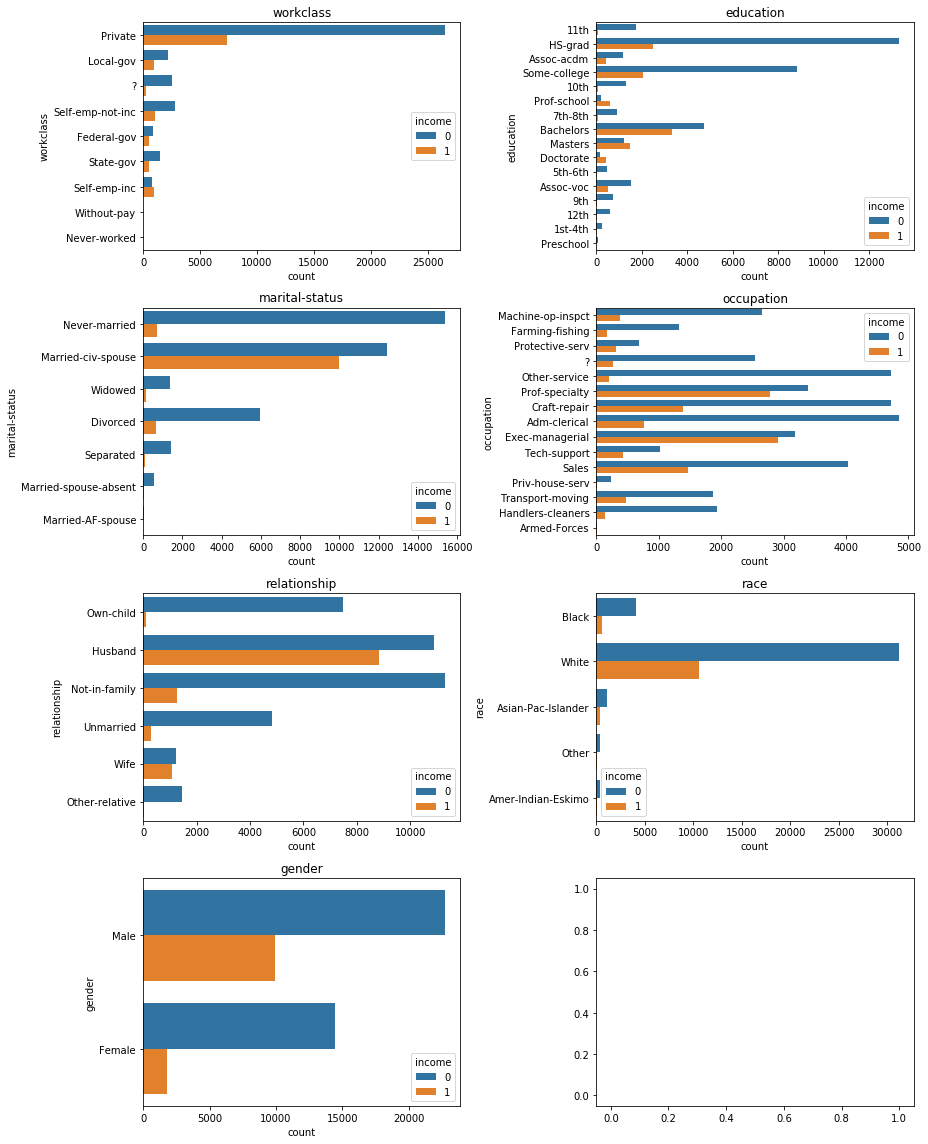

In [38]:
fig, axs = plt.subplots(4,2,figsize=(13,16))
[sns.countplot(y=i, hue='income', data=df_adult,ax=axs.flatten()[j]) for j,i in enumerate(cat_cols[0:-1])]
[axs.flatten()[j].set_title(i) for j,i in enumerate(cat_cols[0:-1])]

fig.tight_layout()
plt.plot()

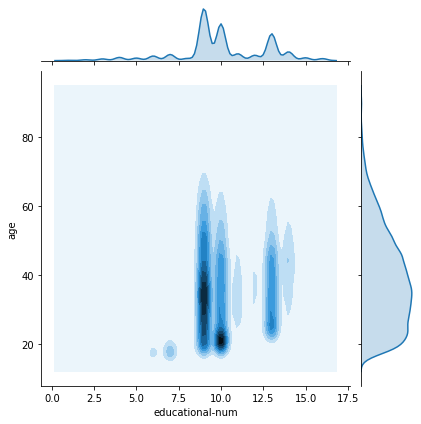

In [41]:
sns.jointplot(x="educational-num", y="age", data=df_adult, kind="kde");

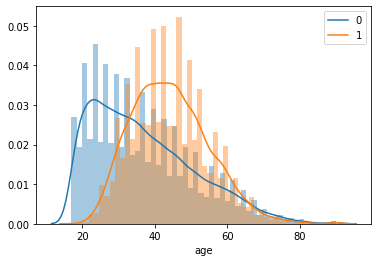

In [57]:
##Lets plot how age is behaving with wages class 
#colors = ["r","b"]
for wages in income:
    sns.distplot(df_adult[df_adult['income'] == wages]['age'], kde_kws={"label": wages})

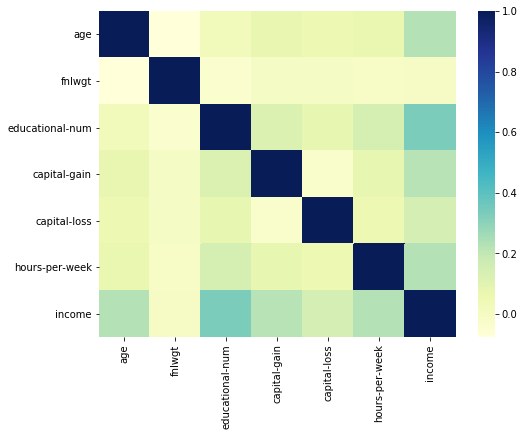

In [64]:
## Lest check the co-relations
plt.figure(figsize=(8,6))
sns.heatmap(df_adult.corr(),cmap = "YlGnBu")

Next, if the feature is not already numerical, we need to encode it as one. We can use pandas Categorical codes for this task. To make things more simple, I will use a loop to apply this on every feature that isn’t an integer.

In [69]:
for feature in df_adult.columns: # Loop through all columns in the dataframe
    if df_adult[feature].dtype == 'object': # Only apply for columns with categorical strings
        df_adult[feature] = pd.Categorical(df_adult[feature]).codes # Replace strings with an integer
    

In [70]:
df_adult.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,4,226802,1,7,4,7,3,2,1,0,0,40,39,0
1,38,4,89814,11,9,2,5,0,4,1,0,0,50,39,0
2,28,2,336951,7,12,2,11,0,4,1,0,0,40,39,1
3,44,4,160323,15,10,2,7,0,2,1,7688,0,40,39,1
4,18,0,103497,15,10,4,0,3,4,0,0,0,30,39,0


In [72]:
df_adult.describe()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
count,48842.000000,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,3.870439,1.896641e+05,10.288420,10.078089,2.618750,6.577700,1.443287,3.668052,0.668482,1079.067626,87.502314,40.422382,36.749355,0.239282
std,13.710510,1.464234,1.056040e+05,3.874492,2.570973,1.507703,4.230509,1.602151,0.845986,0.470764,7452.019058,403.004552,12.391444,7.775343,0.426649
min,17.000000,0.000000,1.228500e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,28.000000,4.000000,1.175505e+05,9.000000,9.000000,2.000000,3.000000,0.000000,4.000000,0.000000,0.000000,0.000000,40.000000,39.000000,0.000000
50%,37.000000,4.000000,1.781445e+05,11.000000,10.000000,2.000000,7.000000,1.000000,4.000000,1.000000,0.000000,0.000000,40.000000,39.000000,0.000000
75%,48.000000,4.000000,2.376420e+05,12.000000,12.000000,4.000000,10.000000,3.000000,4.000000,1.000000,0.000000,0.000000,45.000000,39.000000,0.000000
max,90.000000,8.000000,1.490400e+06,15.000000,16.000000,6.000000,14.000000,5.000000,4.000000,1.000000,99999.000000,4356.000000,99.000000,41.000000,1.000000


In [73]:
## Scalling is not required for Boosting Algorithm

In [78]:
X = df_adult.iloc[:,0:-1]
y = df_adult.income

In [79]:
print(X.shape)
print(y.shape)
print(type(X))
print(type(y))

(48842, 14)
(48842,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [180]:
## Now split the test train
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4,random_state = 42)

In [181]:
print(X_train.shape)
print(y_train.shape)
print(type(X_train))
print(type(y_train))

(29305, 14)
(29305,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [182]:
print(X_test.shape)
print(y_test.shape)
print(type(X_test))
print(type(y_test))

(19537, 14)
(19537,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


### XGBClassifier

I am going to start tuning on the maximum depth of the trees first, along with the min_child_weight, which is very similar to min_samples_split in sklearn’s version of gradient boosted trees. We set the objective to ‘binary:logistic’ since this is a binary classification problem 

In [198]:
cv_param = {"max_depth":[1,2,3,5,7],"min_child_weight" : [1,3,5,6]}
xg_param = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
XGBM = GridSearchCV(XGBClassifier(**xg_param),cv_param,cv = 5,scoring="accuracy",n_jobs=-1)

In [199]:
%time XGBM.fit(X_train,y_train)

Wall time: 5min 27s


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=1000, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=0, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 5, 7],
                         'min_child_weight': [1, 3, 5, 6]},
             pre_dispatch='2*n_jobs', refit=True, return_train

In [185]:
XGBM.best_score_

0.8693738269919808

In [186]:
XGBM.best_params_

{'max_depth': 3, 'min_child_weight': 1}

Based on the GridsearchCV testing performed earlier, we want to utilize the following parameters:

Learning_rate (eta) = 0.1

Subsample, colsample_bytree = 0.8

Max_depth = 3

Min_child_weight = 1

As we have used sklearns cv now we will be utilizing 

**XGBoost's built-in cv which allows early stopping to prevent overfitting**

To increase the performance of XGBoost's speed through many iterations of the training set, and since we are using only XGBoost's API and not sklearn's anymore, we can create a DMatrix. This sorts the data initially to optimize for XGBoost when it builds trees, making the algorithm more efficient. This is especially helpful when you have a very large number of training examples. To create a DMatrix:

In [187]:
## DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed.
xgb_dmat = XGB.DMatrix(X_train,y_train)

Now let's specify our parameters (with slightly different syntax in some places for the XGBoost native API) and set our stopping criteria.

In [188]:
xgb_param = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':5, 'min_child_weight':1} 

In [189]:
%time xgb_cv = XGB.cv(params=xgb_param,dtrain=xgb_dmat,num_boost_round=3000,nfold=5,metrics="error",early_stopping_rounds=200)
# lets take early stopping that minimizes error,
# We need to make sure that we enter metrics inside a list or we may encounter issues!

Wall time: 28.6 s


We can look at our CV results to see how accurate we were with these settings. The output is automatically saved into a pandas dataframe for us.

In [190]:
xgb_cv.tail(5)

,train-error-mean,train-error-std,test-error-mean,test-error-std
197,0.109307,0.001008,0.129807,0.004230
198,0.109154,0.000992,0.129432,0.004286
199,0.108958,0.000997,0.129330,0.004407
200,0.108804,0.000909,0.129295,0.004521
201,0.108608,0.000972,0.129227,0.004344


Our CV test error at this number of iterations is 11.46%, or 88.53% accuracy.

Now that we have our best settings, let's create this as an XGBoost object model that we can reference later.

In [191]:
xgb_param = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':5, 'min_child_weight':1} 

XGB_final = XGB.train(xgb_param, xgb_dmat, num_boost_round = 330)  ### our cv was stopet at 330

### Plotting feature importance

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

<Figure size 432x288 with 0 Axes>

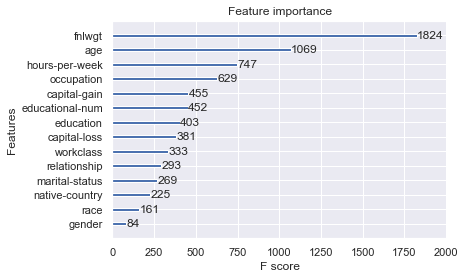

In [192]:
plt.figure(figsize=(6,4))
XGB.plot_importance(XGB_final)
## F score is a metric that simply sums up how many times each feature is split on

This will tell us which features were most important in the series of trees. The **'fnlwgt'** feature seems to have the most importance. Filing **capital gains** was also important, which makes sense given that only those with greater incomes have the ability to invest. Race and sex were not as important.


####  Lets compute the performance on test data

The model has now been tuned using cross-validation grid search through the sklearn API and early stopping through the built-in XGBoost API. Now, we can see how it finally performs on the test set. Does it match our CV performance? First, create another DMatrix (this time for the test data).

In [193]:
xgb_dmat_test = XGB.DMatrix(X_test)

In [194]:
## lets calculate y_pred using DMAT
y_pred_xgb = XGB_final.predict(xgb_dmat_test)
y_pred_xgb

array([0.00669835, 0.0265139 , 0.9983236 , ..., 0.0531757 , 0.7808482 ,
       0.99405175], dtype=float32)

**You can see that the predict function for XGBoost outputs probabilities** by default and not actual class labels. To calculate accuracy we need to convert these to a 0/1 label. We will set 0.5 probability as our threshold.

In [195]:
y_pred_xgb[y_pred_xgb>0.5] = 1
y_pred_xgb[y_pred_xgb<=0.5] = 0

In [196]:
y_pred_xgb

array([0., 0., 1., ..., 0., 1., 1.], dtype=float32)

In [197]:
acc_score = metrics.accuracy_score(y_pred_xgb,y_test)
print("XGB Accuracy Score on test data : {}".format(acc_score))

XGB Accuracy Score on test data : 0.8736244049751754
